In [12]:
import pandas as pd
import numpy as np
import datetime
import itertools

import yfinance as yf
from pandas_datareader import data as pdr 
yf.pdr_override()

import warnings
warnings.filterwarnings('ignore')

import time
import matplotlib.pyplot as plt

from itertools import combinations

In [13]:
ticker = 'SPY'
start_date = '2003-11-01'
end_date = '2022-10-31'
sp500 =  pdr.get_data_yahoo(ticker, start_date, end_date)
sp500

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2003-11-03,105.750000,106.610001,105.709999,105.989998,72.243500,37589300
2003-11-04,105.989998,106.269997,105.580002,105.760002,72.086754,31421600
2003-11-05,105.489998,105.970001,104.900002,105.839996,72.141251,33558800
2003-11-06,105.599998,106.440002,105.099998,106.400002,72.522987,28392300
2003-11-07,106.639999,106.720001,105.570000,105.610001,71.984497,31723200
...,...,...,...,...,...,...
2022-10-24,375.890015,380.059998,373.109985,378.869995,372.998169,85436900
2022-10-25,378.790009,385.250000,378.670013,384.920013,378.954437,78846300
2022-10-26,381.619995,387.579987,381.350006,382.019989,376.099335,104087300


# Define momentum indicators

In [14]:
def rsi(price, window, buy, sell, exit): # buy at rsi 30, sell at 70, exit at 50
    df = pd.DataFrame()
    df['Adj Close'] = price[['Adj Close']].copy()
    delta = df['Adj Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    average_gain = gain.rolling(window=window).mean()
    average_loss = loss.rolling(window=window).mean()
    rs = average_gain  / average_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df["position"] = np.nan
    long  = (df["RSI"].shift(1) < buy) & (df["RSI"] >= buy) & (df["position"].shift(1) !=-1)
    short = (df["RSI"].shift(1) > sell) & (df["RSI"] <= sell) & (df["position"].shift(1) !=-1)
    exit  = ((df['RSI'].shift(1) > exit) & (df['RSI'] <= exit)) | ((df['RSI'].shift(1) < exit) & (df['RSI'] >= exit))
    df["position"] = np.where(long,1,df["position"])
    df["position"] = np.where(short,-1,df["position"])
    df["position"] = np.where(exit,0,df["position"])
    df["position"].ffill(inplace = True)
    df['position'] = df['position'].fillna(0)
    df["action"] = df["position"].diff()
    return df['action']

def sma_strategy(price, short, long):
    df = pd.DataFrame()
    df['Adj Close'] = price[['Adj Close']].copy()
    df['short_sma'] = df['Adj Close'].rolling(short).mean()
    df['long_sma'] = df['Adj Close'].rolling(long).mean()
    df['position'] = 0.0
    df['position'] = np.where(df['short_sma'] > df['long_sma'], 1, 0)
    df['action'] = df['position'].diff()
    return df['action']

def threshold_strategy(price, window, threshold):
    df = pd.DataFrame()
    df['Adj Close'] = price[['Adj Close']].copy()
    df['short_sma'] = df['Adj Close'].rolling(window).mean()
    df['distance'] = df['Adj Close'] - df['short_sma']
    df['rolling_std'] = df['Adj Close'].rolling(window).std()
    df['rolling_threshold'] = threshold*df['rolling_std']
    df['position'] = np.where(df['distance'] > df['rolling_threshold'], -1, np.nan)
    df['position'] = np.where(df['distance'] < df['rolling_threshold'], 1, df['position'])
    df['position'] = df['position'].ffill()
    df['action'] = df['position'].diff()
    df['action'] = df['action'].replace(-2,-1)
    df['action'] = df['action'].replace(2,1)
    return df['action']

def macd(price, short, long, signal):
    df = pd.DataFrame()
    df['Adj Close'] = price[['Adj Close']].copy()
    df['short_EMA'] = df['Adj Close'].ewm(span=short, adjust=False).mean()
    df['long_EMA'] = df['Adj Close'].ewm(span=long, adjust=False).mean()
    df['MACD'] = df['short_EMA'] - df['long_EMA']
    df['signal'] = df['MACD'].ewm(span=signal, adjust=False).mean()
    df["position"] = np.where((df['MACD'] > df['signal']), 1, -1)
    df["position"] = df["position"].shift(1)
    df["position"][:short+long] = 0 
    df["position"].fillna(0, inplace=True)
    df["action"] = df["position"].diff() 
    df["action"].fillna(0, inplace=True)
    df["action"]=np.sign(df["signal"])
    return df['action']

def ADX_signal(df, period=14):
    df = df.copy()
    df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']), 
                         df['High'] - df['High'].shift(1), 0)
    df['+DM'] = np.where(df['+DM'] < 0, 0, df['+DM'])

    df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)), 
                         df['Low'].shift(1) - df['Low'], 0)
    df['-DM'] = np.where(df['-DM'] < 0, 0, df['-DM'])

    tr_list = [df['High'] - df['Low'], df['High'] - df['Close'].shift(), df['Close'].shift() - df['Low']]
    df['TR'] = pd.concat(tr_list, axis=1).max(axis=1)
    df['TR'] = df['TR'].rolling(window=period).sum()

    df['+DI'] = 100 * (df['+DM'].rolling(window=period).sum() / df['TR'])
    df['-DI'] = 100 * (df['-DM'].rolling(window=period).sum() / df['TR'])

    df['ADX'] = abs((df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])) * 100
    df['ADX'] = df['ADX'].rolling(window=period).mean()

    df['action'] = np.where((df['+DI'] > df['-DI']) & (df['ADX'] > 25), 1, 
                            np.where((df['+DI'] < df['-DI']) & (df['ADX'] > 25), -1, 0))
    return df['action']

def Aroon_signal(df, period=25):
    df = df.copy()
    df['Aroon_down'] = df['Low'].rolling(window=period, min_periods=1).apply(lambda x: (x.argmin() / (period - 1)) * 100, raw=True)
    df['Aroon_up'] = df['High'].rolling(window=period, min_periods=1).apply(lambda x: (x.argmax() / (period - 1)) * 100, raw=True)
    df['Aroon_Oscillator'] = df['Aroon_up'] - df['Aroon_down']
    df['action'] = np.where(df['Aroon_up'] > df['Aroon_down'], 1, np.where(df['Aroon_up'] < df['Aroon_down'], -1, 0))
    return df['action']

def WilliamsR_signal(df, period=14):
    df['Williams_%R'] = ((df['High'].rolling(window=period).max() - df['Close']) / 
                         (df['High'].rolling(window=period).max() - df['Low'].rolling(window=period).min())) * -100

    df['action'] = np.where(df['Williams_%R'] > -80, 1, 
                            np.where(df['Williams_%R'] < -20, -1, 0))
    return df['action']

def CCI_signal(df, period=20):
    df = df.copy()
    TP = (df['High'] + df['Low'] + df['Close']) / 3
    CCI = (TP - TP.rolling(window=period).mean()) / (0.015 * TP.rolling(window=period).std())
    df['CCI'] = CCI
    df['action'] = np.where(df['CCI'] > 100, -1, np.where(df['CCI'] < -100, 1, 0))
    return df['action']

def ROC_signal(df, period=12):
    df = df.copy()
    df['ROC'] = df['Close'].diff(period) / df['Close'].shift(period) * 100
    df['action'] = np.where(df['ROC'] > 0, 1, np.where(df['ROC'] < 0, -1, 0))
    return df['action']

def EFI_signal(df, period=13):
    df = df.copy()
    df['EFI'] = df['Close'].diff(1) * df['Volume']
    df['EFI_MA'] = df['EFI'].rolling(window=period).mean()
    df['action'] = np.where(df['EFI'] > df['EFI_MA'], 1, np.where(df['EFI'] < df['EFI_MA'], -1, 0))
    return df['action']

def KC_signal(df, period=20):
    df = df.copy()
    middle_line = df['Close'].ewm(span=period, adjust=False).mean()
    range_ma = (df['High'] - df['Low']).rolling(window=period).mean()
    df['upper_KC'] = middle_line + (2 * range_ma)
    df['lower_KC'] = middle_line - (2 * range_ma)
    
    df['action'] = np.where(df['Close'] > df['upper_KC'], 1, 
                            np.where(df['Close'] < df['lower_KC'], -1, 0))
    return df['action']

def TEMA_signal(df, period=30):
    df = df.copy()
    ema1 = df['Close'].ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    ema3 = ema2.ewm(span=period, adjust=False).mean()
    df['TEMA'] = 3 * (ema1 - ema2) + ema3
    df['action'] = np.where(df['Close'] > df['TEMA'], 1, 
                            np.where(df['Close'] < df['TEMA'], -1, 0))
    return df['action']

def TRIX_signal(df, period=15):
    df = df.copy()
    ema1 = df['Close'].ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    ema3 = ema2.ewm(span=period, adjust=False).mean()
    df['TRIX'] = ema3.pct_change() * 100
    df['signal_line'] = df['TRIX'].ewm(span=period, adjust=False).mean()
    df['action'] = np.where(df['TRIX'] > df['signal_line'], 1, 
                            np.where(df['TRIX'] < df['signal_line'], -1, 0))
    return df['action']


# For each indicators, find the optimal parameters that generate the highest cumulative return

In [15]:
def cum_return(price, action):
    df = price.copy()
    df['action'] = action.copy()
    df['passive_log_return'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
    df['strategy_log_return'] = df['action'].shift(1)*df['passive_log_return']
    df['cum_return'] = df['strategy_log_return'].cumsum().apply(np.exp)
    #df['cum_return'].plot(title='cum return (%)')
    return df

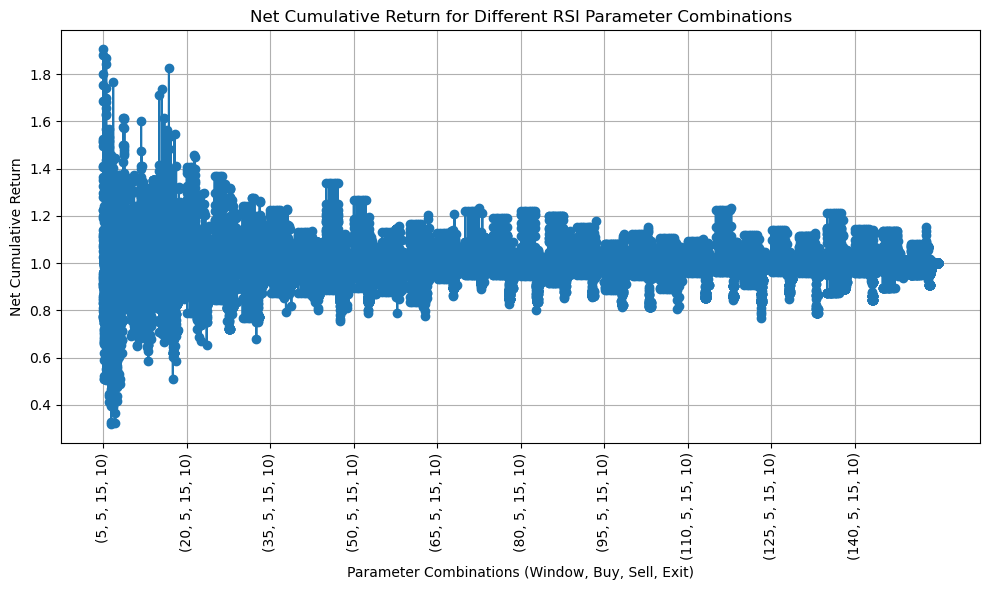

Best Parameters: (5, 5, 55, 25), Best Cumulative Return: 1.90608709585909
Elapsed Time: 978.13 seconds


In [16]:
# Optimization process for RSI
start_time = time.time()

window_range = range(5, 155, 5)
buy_range = range(5, 155, 5)
sell_range = range(5, 155, 5)
exit_range = range(5, 155, 5)

param_combinations = [
    (window, buy, sell, exit)
    for window in window_range
    for buy in buy_range
    for sell in sell_range
    for exit in exit_range
    if buy < sell and buy < exit < sell and buy != sell != exit
]

best_cum_return = -np.inf
best_params = None
cum_returns = []
combinations = []

for window, buy, sell, exit in param_combinations:
    rsi_data = rsi(sp500, window, buy, sell, exit)
    net_cum_return = cum_return(sp500, rsi_data)['cum_return'].iloc[-1]    
    cum_returns.append(net_cum_return)
    combinations.append((window, buy, sell, exit))

    if net_cum_return > best_cum_return:
        best_cum_return = net_cum_return
        best_params = (window, buy, sell, exit)

# Plotting the results
plt.figure(figsize=(10, 6))
tick_interval = max(len(combinations) // 10, 1)
tick_positions = range(0, len(combinations), tick_interval)
tick_labels = [str(combinations[i]) for i in tick_positions]

plt.plot(range(len(combinations)), cum_returns, 'o-')
plt.title('Net Cumulative Return for Different RSI Parameter Combinations')
plt.xlabel('Parameter Combinations (Window, Buy, Sell, Exit)')
plt.ylabel('Net Cumulative Return')
plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.tight_layout()
plt.grid(True)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


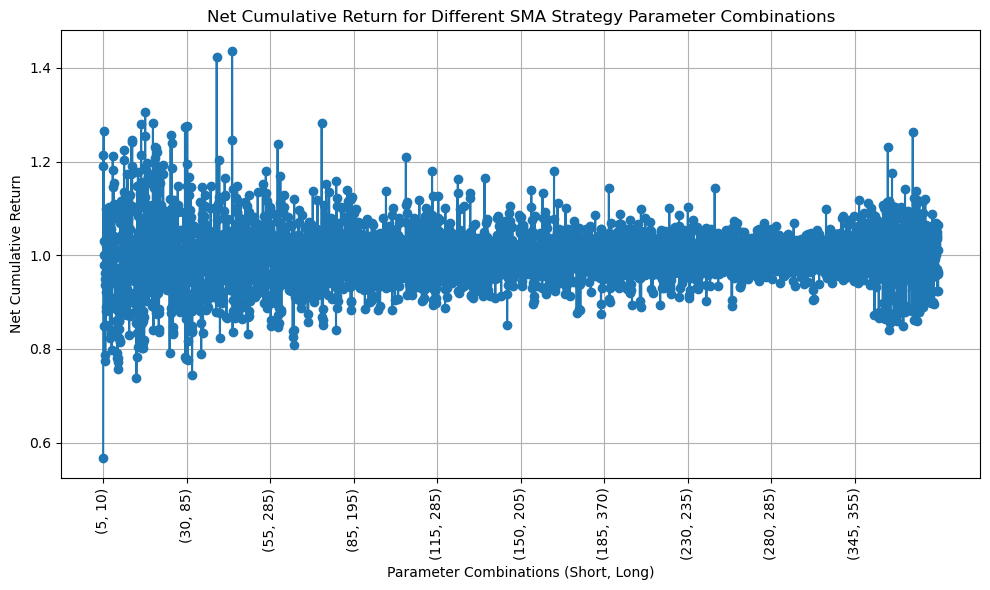

Best Parameters: (45, 50), Best Cumulative Return: 1.4365457621250777
Elapsed Time: 22.91 seconds


In [17]:
# Optimization process for SMA Strategy
start_time = time.time()

short_range = range(5, 505, 5)
long_range = range(5, 505, 5)

param_combinations = [
    (short, long)
    for short in short_range
    for long in long_range
    if short < long
]

best_cum_return = -np.inf
best_params = None
cum_returns = []
combinations = []

for short, long in param_combinations:
    sma_data = sma_strategy(sp500, short, long)
    net_cum_return = cum_return(sp500, sma_data)['cum_return'].iloc[-1]
    cum_returns.append(net_cum_return)
    combinations.append((short, long))

    if net_cum_return > best_cum_return:
        best_cum_return = net_cum_return
        best_params = (short, long)

# Plotting the results for SMA Strategy
plt.figure(figsize=(10, 6))
tick_interval = max(len(combinations) // 10, 1)
tick_positions = range(0, len(combinations), tick_interval)
tick_labels = [str(combinations[i]) for i in tick_positions]

plt.plot(range(len(combinations)), cum_returns, 'o-')
plt.title('Net Cumulative Return for Different SMA Strategy Parameter Combinations')
plt.xlabel('Parameter Combinations (Short, Long)')
plt.ylabel('Net Cumulative Return')
plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.tight_layout()
plt.grid(True)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


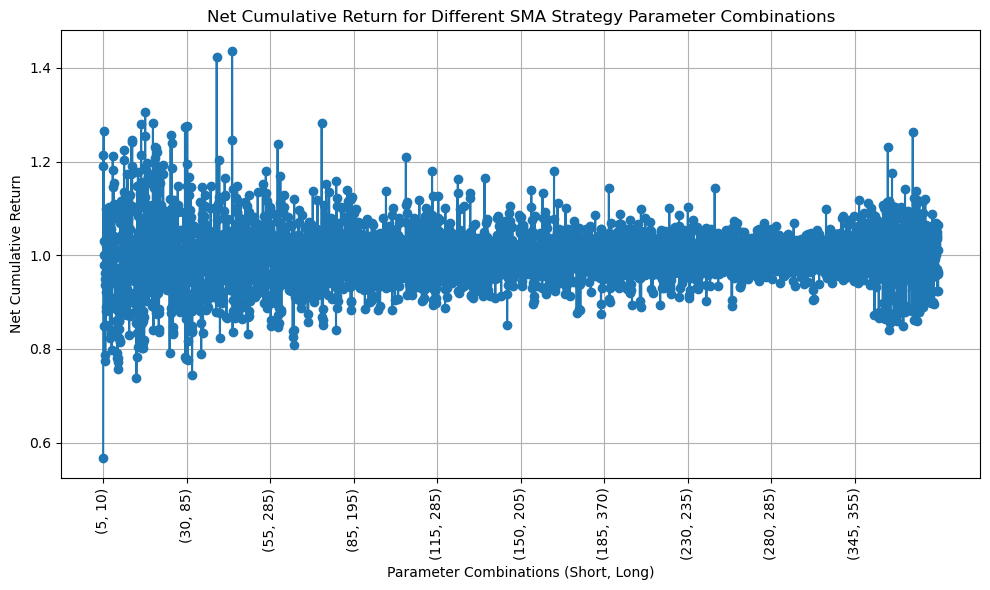

Best Parameters: (45, 50), Best Cumulative Return: 1.4365457621250777
Elapsed Time: 27.29 seconds


In [18]:
# Optimization process for SMA Strategy
start_time = time.time()

short_range = range(5, 505, 5)
long_range = range(5, 505, 5)

param_combinations = [
    (short, long)
    for short in short_range
    for long in long_range
    if short < long
]

best_cum_return = -np.inf
best_params = None
cum_returns = []
combinations = []

for short, long in param_combinations:
    sma_data = sma_strategy(sp500, short, long)
    net_cum_return = cum_return(sp500, sma_data)['cum_return'].iloc[-1]
    cum_returns.append(net_cum_return)
    combinations.append((short, long))

    if net_cum_return > best_cum_return:
        best_cum_return = net_cum_return
        best_params = (short, long)

# Plotting the results for SMA Strategy
plt.figure(figsize=(10, 6))
tick_interval = max(len(combinations) // 10, 1)
tick_positions = range(0, len(combinations), tick_interval)
tick_labels = [str(combinations[i]) for i in tick_positions]

plt.plot(range(len(combinations)), cum_returns, 'o-')
plt.title('Net Cumulative Return for Different SMA Strategy Parameter Combinations')
plt.xlabel('Parameter Combinations (Short, Long)')
plt.ylabel('Net Cumulative Return')
plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.tight_layout()
plt.grid(True)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


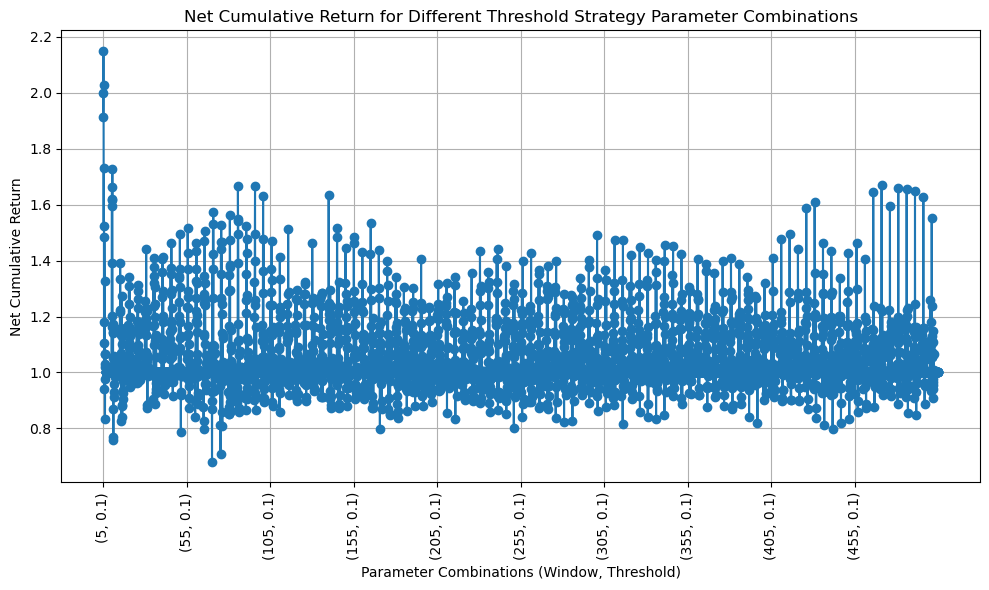

Best Parameters: (5, 0.30000000000000004), Best Cumulative Return: 2.149800689941759
Elapsed Time: 38.69 seconds


In [19]:
# Optimization process for Threshold Strategy
start_time = time.time()

window_range = range(5, 505, 5)
threshold_range = np.arange(0.1, 6.1, 0.1)

param_combinations = list(itertools.product(window_range, threshold_range))

best_cum_return = -np.inf
best_params = None
cum_returns = []
combinations = []

for window, threshold in param_combinations:
    threshold_data = threshold_strategy(sp500, window, threshold)
    net_cum_return = cum_return(sp500, threshold_data)['cum_return'].iloc[-1]
    cum_returns.append(net_cum_return)
    combinations.append((window, threshold))

    if net_cum_return > best_cum_return:
        best_cum_return = net_cum_return
        best_params = (window, threshold)

# Plotting the results for Threshold Strategy
plt.figure(figsize=(10, 6))
tick_interval = max(len(combinations) // 10, 1)
tick_positions = range(0, len(combinations), tick_interval)
tick_labels = [str(combinations[i]) for i in tick_positions]

plt.plot(range(len(combinations)), cum_returns, 'o-')
plt.title('Net Cumulative Return for Different Threshold Strategy Parameter Combinations')
plt.xlabel('Parameter Combinations (Window, Threshold)')
plt.ylabel('Net Cumulative Return')
plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.tight_layout()
plt.grid(True)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


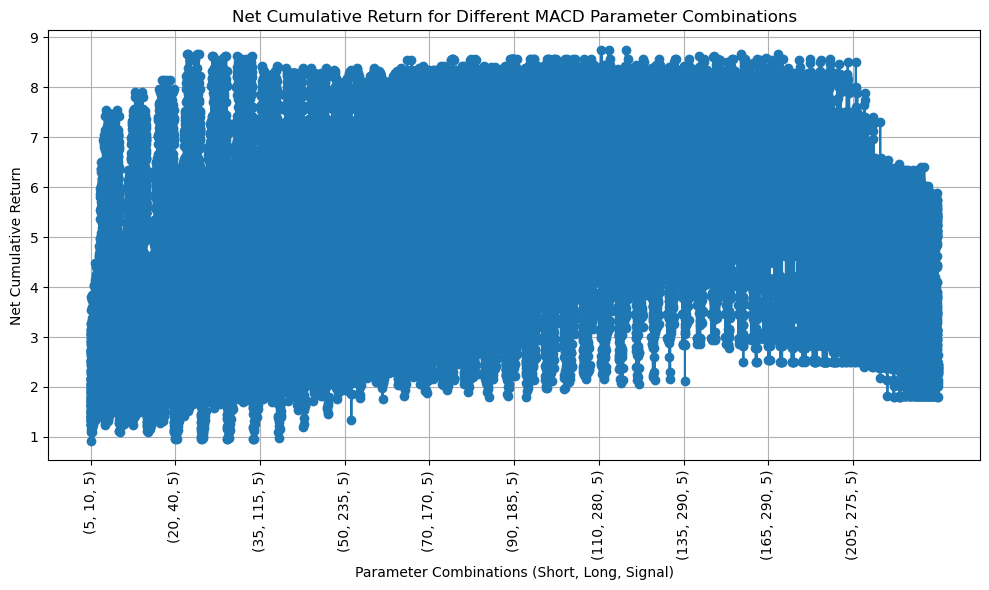

Best Parameters: (115, 120, 195), Best Cumulative Return: 8.7492373725767
Elapsed Time: 645.35 seconds


In [20]:
# Optimization process for MACD
start_time = time.time()

short_range = range(5, 305, 5)
long_range = range(5, 305, 5)
signal_range = range(5, 305, 5)

param_combinations_macd = [
    (short, long, signal)
    for short in short_range
    for long in long_range
    for signal in signal_range
    if short < long
]

best_cum_return = -np.inf
best_params = None
cum_returns = []
combinations = []

for short, long, signal in param_combinations_macd:
    macd_data = macd(sp500, short, long, signal)
    net_cum_return = cum_return(sp500, macd_data)['cum_return'].iloc[-1]
    cum_returns.append(net_cum_return)
    combinations.append((short, long, signal))

    if net_cum_return > best_cum_return:
        best_cum_return = net_cum_return
        best_params = (short, long, signal)

# Plotting the results for MACD
plt.figure(figsize=(10, 6))
tick_interval = max(len(combinations) // 10, 1)
tick_positions = np.arange(0, len(combinations), tick_interval)
tick_labels = [str(combinations[i]) for i in tick_positions]

plt.plot(np.arange(len(combinations)), cum_returns, 'o-')
plt.title('Net Cumulative Return for Different MACD Parameter Combinations')
plt.xlabel('Parameter Combinations (Short, Long, Signal)')
plt.ylabel('Net Cumulative Return')
plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.tight_layout()
plt.grid(True)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


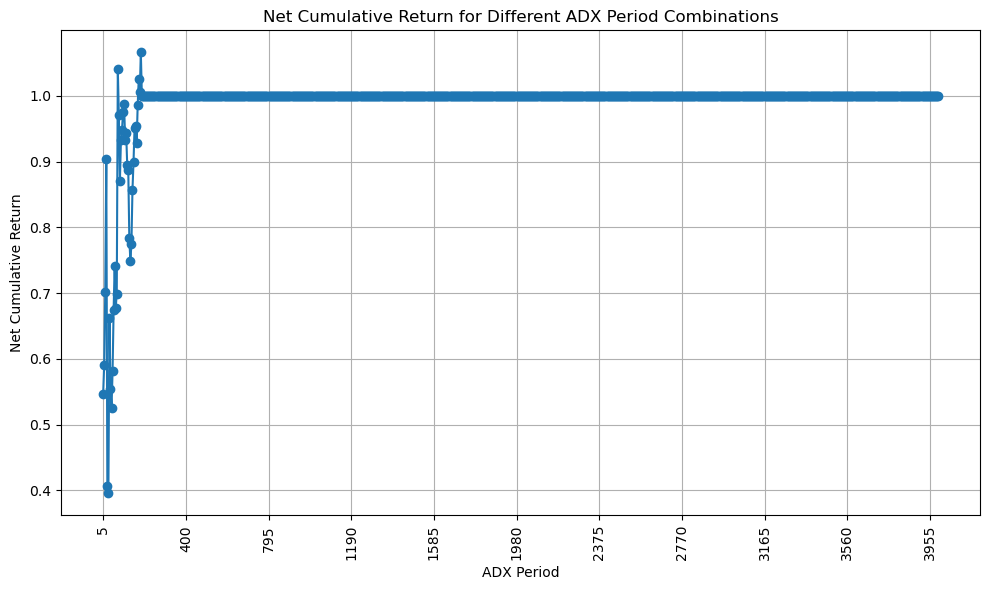

Best Parameters: 185, Best Cumulative Return: 1.0659752220046883
Elapsed Time: 6.66 seconds


In [21]:
# Optimization process for ADX
start_time = time.time()

period_range = range(5, 4000, 5)

best_cum_return = -np.inf
best_params = None
cum_returns = []
combinations = []

for period in period_range:
    adx_data = ADX_signal(sp500, period)
    net_cum_return = cum_return(sp500, adx_data)['cum_return'].iloc[-1]
    cum_returns.append(net_cum_return)
    combinations.append(period)

    if net_cum_return > best_cum_return:
        best_cum_return = net_cum_return
        best_params = period

# Plotting the results for ADX
plt.figure(figsize=(10, 6))
tick_interval = max(len(combinations) // 10, 1)
tick_positions = np.arange(0, len(combinations), tick_interval)
tick_labels = [str(combinations[i]) for i in tick_positions]

plt.plot(np.arange(len(combinations)), cum_returns, 'o-')
plt.title('Net Cumulative Return for Different ADX Period Combinations')
plt.xlabel('ADX Period')
plt.ylabel('Net Cumulative Return')
plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.tight_layout()
plt.grid(True)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


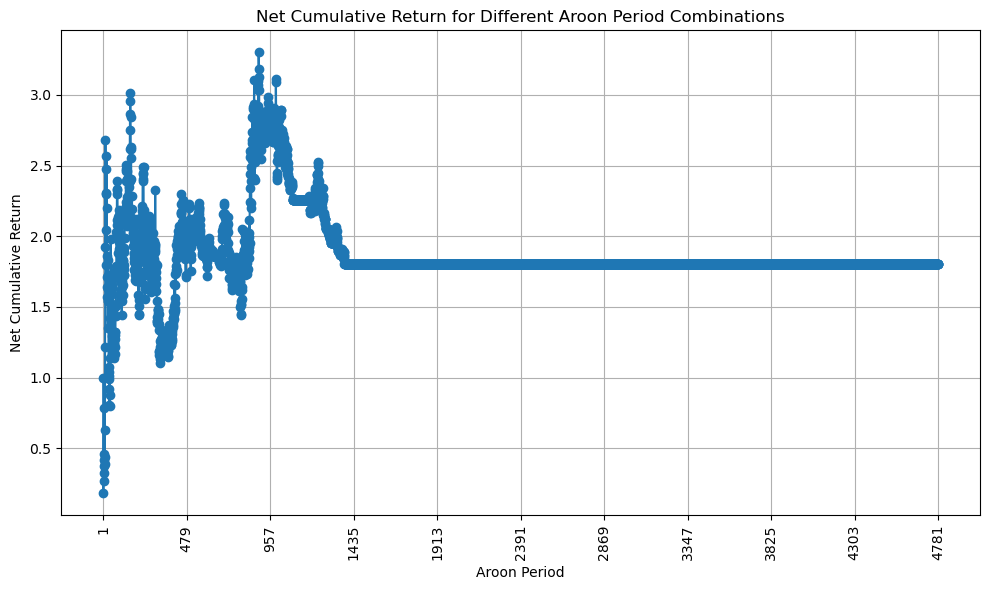

Best Parameters: 891, Best Cumulative Return: 3.3016718718717817
Elapsed Time: 88.31 seconds


In [22]:
# Optimization process for Aroon
start_time = time.time()

period_range = range(1, 4782, 1)

best_cum_return = -np.inf
best_params = None
cum_returns = []
combinations = []

for period in period_range:
    aroon_data = Aroon_signal(sp500, period)
    net_cum_return = cum_return(sp500, aroon_data)['cum_return'].iloc[-1]
    cum_returns.append(net_cum_return)
    combinations.append(period)

    if net_cum_return > best_cum_return:
        best_cum_return = net_cum_return
        best_params = period

# Plotting the results for Aroon
plt.figure(figsize=(10, 6))
tick_interval = max(len(combinations) // 10, 1)
tick_positions = np.arange(0, len(combinations), tick_interval)
tick_labels = [str(combinations[i]) for i in tick_positions]

plt.plot(np.arange(len(combinations)), cum_returns, 'o-')
plt.title('Net Cumulative Return for Different Aroon Period Combinations')
plt.xlabel('Aroon Period')
plt.ylabel('Net Cumulative Return')
plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.tight_layout()
plt.grid(True)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


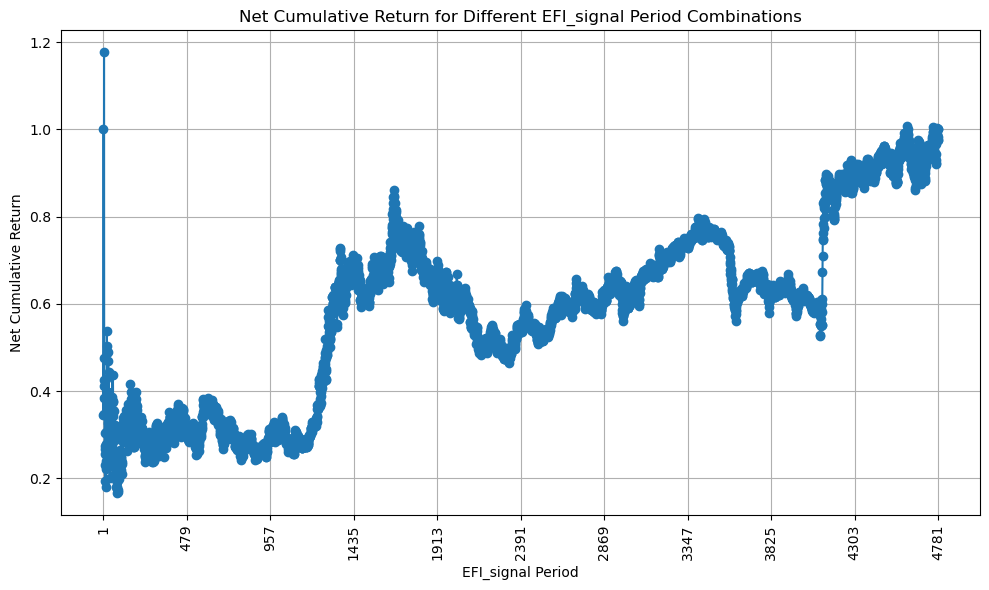

Best Parameters: 6, Best Cumulative Return: 1.176554193242171
Elapsed Time: 13.45 seconds


In [23]:
# Optimization process for EFI_signal
start_time = time.time()

period_range = range(1, 4782, 1)

best_cum_return = -np.inf
best_params = None
cum_returns = []
combinations = []

for period in period_range:
    EFI_signal_data = EFI_signal(sp500, period)
    net_cum_return = cum_return(sp500, EFI_signal_data)['cum_return'].iloc[-1]
    cum_returns.append(net_cum_return)
    combinations.append(period)

    if net_cum_return > best_cum_return:
        best_cum_return = net_cum_return
        best_params = period

# Plotting the results for EFI_signal
plt.figure(figsize=(10, 6))
tick_interval = max(len(combinations) // 10, 1)
tick_positions = np.arange(0, len(combinations), tick_interval)
tick_labels = [str(combinations[i]) for i in tick_positions]

plt.plot(np.arange(len(combinations)), cum_returns, 'o-')
plt.title('Net Cumulative Return for Different EFI_signal Period Combinations')
plt.xlabel('EFI_signal Period')
plt.ylabel('Net Cumulative Return')
plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.tight_layout()
plt.grid(True)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


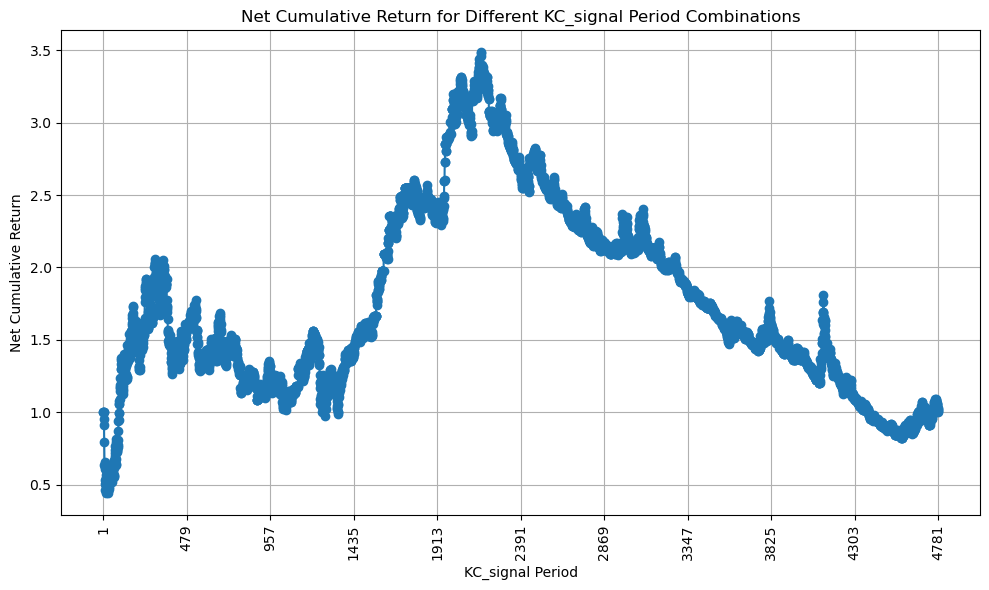

Best Parameters: 2162, Best Cumulative Return: 3.485637146343468
Elapsed Time: 15.52 seconds


In [24]:
# Optimization process for KC_signal
start_time = time.time()

period_range = range(1, 4782, 1)

best_cum_return = -np.inf
best_params = None
cum_returns = []
combinations = []

for period in period_range:
    KC_signal_data = KC_signal(sp500, period)
    net_cum_return = cum_return(sp500, KC_signal_data)['cum_return'].iloc[-1]
    cum_returns.append(net_cum_return)
    combinations.append(period)

    if net_cum_return > best_cum_return:
        best_cum_return = net_cum_return
        best_params = period

# Plotting the results for KC_signal
plt.figure(figsize=(10, 6))
tick_interval = max(len(combinations) // 10, 1)
tick_positions = np.arange(0, len(combinations), tick_interval)
tick_labels = [str(combinations[i]) for i in tick_positions]

plt.plot(np.arange(len(combinations)), cum_returns, 'o-')
plt.title('Net Cumulative Return for Different KC_signal Period Combinations')
plt.xlabel('KC_signal Period')
plt.ylabel('Net Cumulative Return')
plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.tight_layout()
plt.grid(True)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


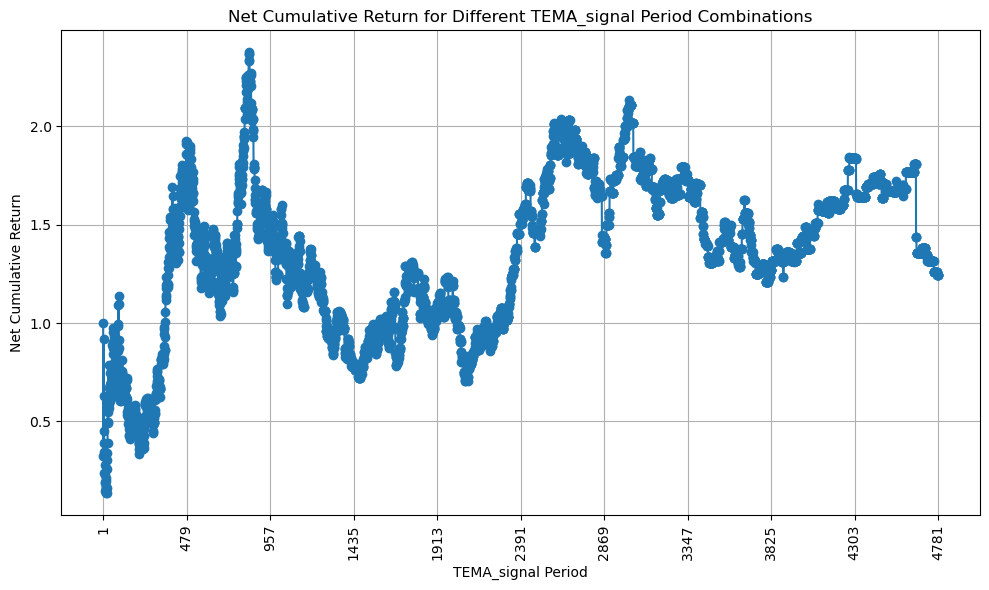

Best Parameters: 836, Best Cumulative Return: 2.375969079140344
Elapsed Time: 13.08 seconds


In [25]:
# Optimization process for TEMA_signal
start_time = time.time()

period_range = range(1, 4782, 1)


best_cum_return = -np.inf
best_params = None
cum_returns = []
combinations = []

for period in period_range:
    TEMA_signal_data = TEMA_signal(sp500, period)
    net_cum_return = cum_return(sp500, TEMA_signal_data)['cum_return'].iloc[-1]
    cum_returns.append(net_cum_return)
    combinations.append(period)

    if net_cum_return > best_cum_return:
        best_cum_return = net_cum_return
        best_params = period

# Plotting the results for TEMA_signal
plt.figure(figsize=(10, 6))
tick_interval = max(len(combinations) // 10, 1)
tick_positions = np.arange(0, len(combinations), tick_interval)
tick_labels = [str(combinations[i]) for i in tick_positions]

plt.plot(np.arange(len(combinations)), cum_returns, 'o-')
plt.title('Net Cumulative Return for Different TEMA_signal Period Combinations')
plt.xlabel('TEMA_signal Period')
plt.ylabel('Net Cumulative Return')
plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.tight_layout()
plt.grid(True)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


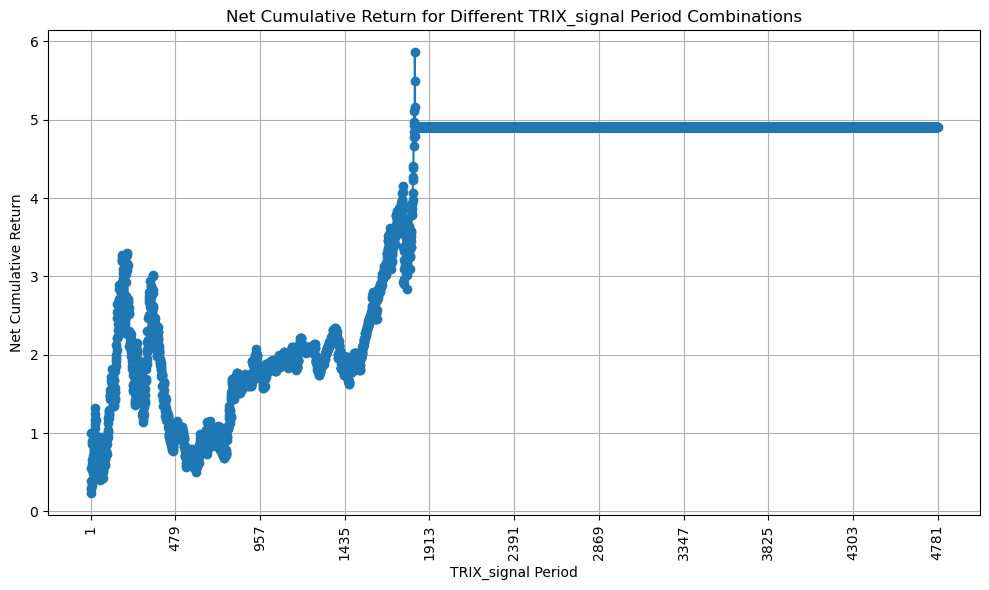

Best Parameters: 1831, Best Cumulative Return: 5.859195383505847
Elapsed Time: 16.19 seconds


In [26]:
# Optimization process for TRIX_signal
start_time = time.time()

period_range = range(1, 4782, 1)
best_cum_return = -np.inf
best_params = None
cum_returns = []
combinations = []

for period in period_range:
    TRIX_signal_data = TRIX_signal(sp500, period)
    net_cum_return = cum_return(sp500, TRIX_signal_data)['cum_return'].iloc[-1]
    cum_returns.append(net_cum_return)
    combinations.append(period)

    if net_cum_return > best_cum_return:
        best_cum_return = net_cum_return
        best_params = period

# Plotting the results for TRIX_signal
plt.figure(figsize=(10, 6))
tick_interval = max(len(combinations) // 10, 1)
tick_positions = np.arange(0, len(combinations), tick_interval)
tick_labels = [str(combinations[i]) for i in tick_positions]

plt.plot(np.arange(len(combinations)), cum_returns, 'o-')
plt.title('Net Cumulative Return for Different TRIX_signal Period Combinations')
plt.xlabel('TRIX_signal Period')
plt.ylabel('Net Cumulative Return')
plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.tight_layout()
plt.grid(True)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


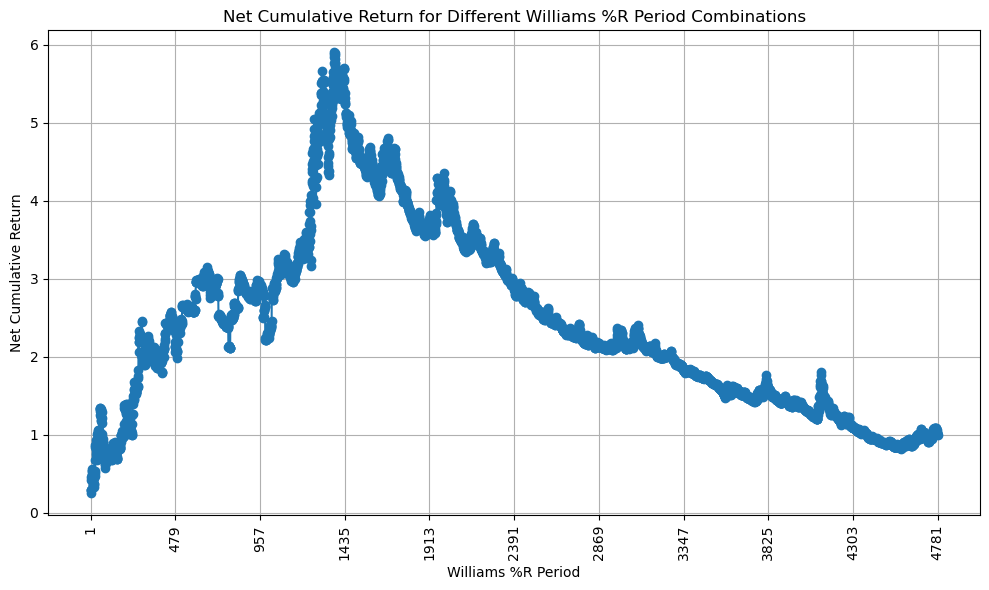

Best Parameters: 1377, Best Cumulative Return: 5.903983568374409
Elapsed Time: 17.85 seconds


In [27]:
# Optimization process for Williams %R
start_time = time.time()

period_range = range(1, 4782, 1)
best_cum_return = -np.inf
best_params = None
cum_returns = []
combinations = []

for period in period_range:
    williams_data = WilliamsR_signal(sp500, period)
    net_cum_return = cum_return(sp500, williams_data)['cum_return'].iloc[-1]
    cum_returns.append(net_cum_return)
    combinations.append(period)

    if net_cum_return > best_cum_return:
        best_cum_return = net_cum_return
        best_params = period

# Plotting the results for Williams %R
plt.figure(figsize=(10, 6))
tick_interval = max(len(combinations) // 10, 1)
tick_positions = np.arange(0, len(combinations), tick_interval)
tick_labels = [str(combinations[i]) for i in tick_positions]

plt.plot(np.arange(len(combinations)), cum_returns, 'o-')
plt.title('Net Cumulative Return for Different Williams %R Period Combinations')
plt.xlabel('Williams %R Period')
plt.ylabel('Net Cumulative Return')
plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.tight_layout()
plt.grid(True)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")


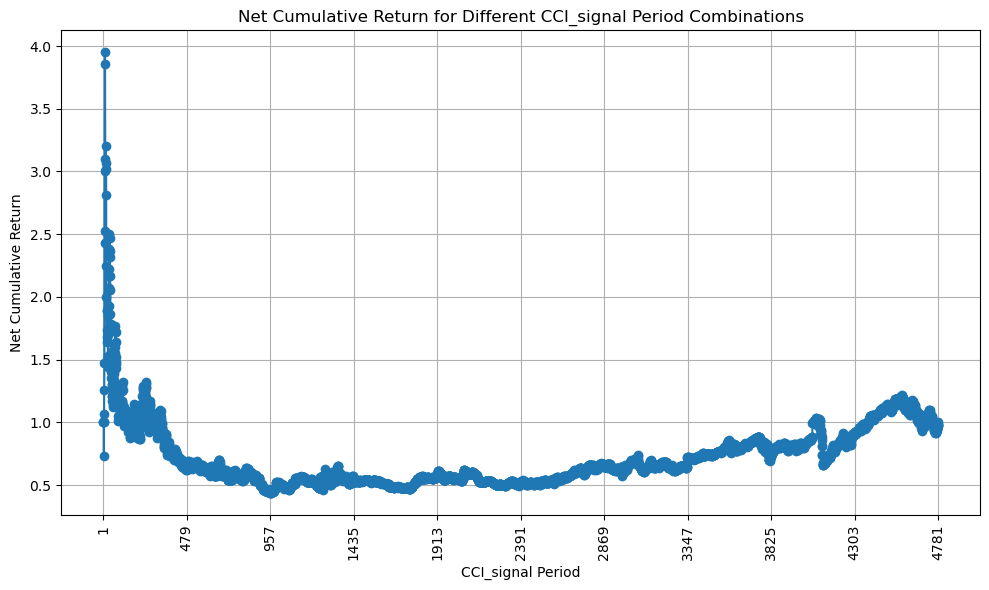

Best Parameters: 11, Best Cumulative Return: 3.9497662332000356
Elapsed Time: 15.41 seconds


In [28]:
# Optimization process for CCI_signal
start_time = time.time()

period_range = range(1, 4782, 1)
best_cum_return = -np.inf
best_params = None
cum_returns = []
combinations = []

for period in period_range:
    CCI_signal_data = CCI_signal(sp500, period)
    net_cum_return = cum_return(sp500, CCI_signal_data)['cum_return'].iloc[-1]
    cum_returns.append(net_cum_return)
    combinations.append(period)

    if net_cum_return > best_cum_return:
        best_cum_return = net_cum_return
        best_params = period

# Plotting the results for CCI_signal
plt.figure(figsize=(10, 6))
tick_interval = max(len(combinations) // 10, 1)
tick_positions = np.arange(0, len(combinations), tick_interval)
tick_labels = [str(combinations[i]) for i in tick_positions]

plt.plot(np.arange(len(combinations)), cum_returns, 'o-')
plt.title('Net Cumulative Return for Different CCI_signal Period Combinations')
plt.xlabel('CCI_signal Period')
plt.ylabel('Net Cumulative Return')
plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.tight_layout()
plt.grid(True)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

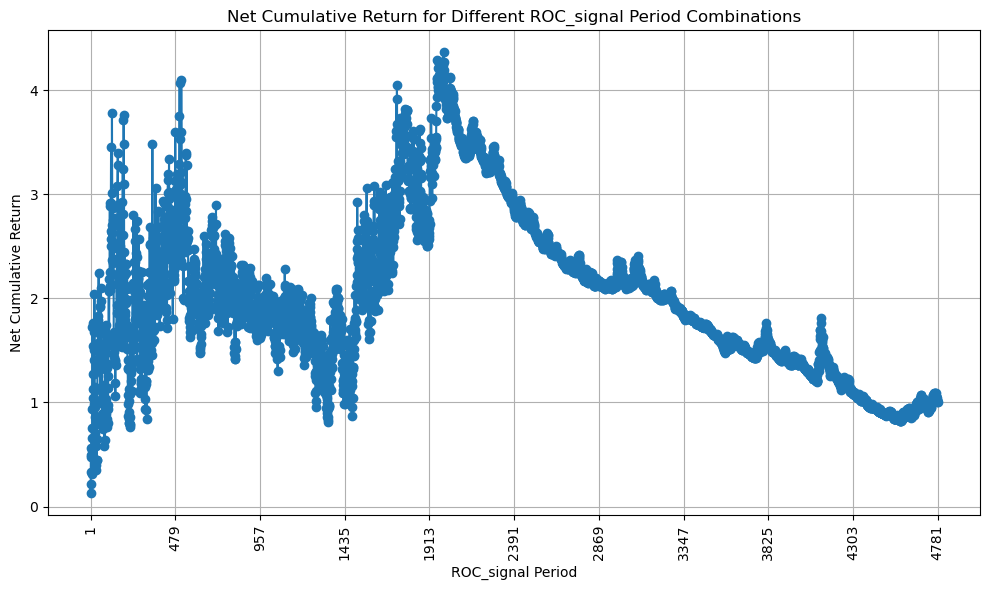

Best Parameters: 1993, Best Cumulative Return: 4.362927793864231
Elapsed Time: 11.64 seconds


In [29]:
# Optimization process for ROC_signal
start_time = time.time()

period_range = range(1, 4782, 1)
best_cum_return = -np.inf
best_params = None
cum_returns = []
combinations = []

for period in period_range:
    ROC_signal_data = ROC_signal(sp500, period)
    net_cum_return = cum_return(sp500, ROC_signal_data)['cum_return'].iloc[-1]
    cum_returns.append(net_cum_return)
    combinations.append(period)

    if net_cum_return > best_cum_return:
        best_cum_return = net_cum_return
        best_params = period

# Plotting the results for ROC_signal
plt.figure(figsize=(10, 6))
tick_interval = max(len(combinations) // 10, 1)
tick_positions = np.arange(0, len(combinations), tick_interval)
tick_labels = [str(combinations[i]) for i in tick_positions]

plt.plot(np.arange(len(combinations)), cum_returns, 'o-')
plt.title('Net Cumulative Return for Different ROC_signal Period Combinations')
plt.xlabel('ROC_signal Period')
plt.ylabel('Net Cumulative Return')
plt.xticks(tick_positions, tick_labels, rotation='vertical')
plt.tight_layout()
plt.grid(True)
plt.show()

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

<font color='red'> (Note) </font> For single indicator, MACD generates the highest cumulative return of 775%. The paramters are: short window = 115, long iwndow = 120, singal window = 195

# Does combining 2 indicators (with the respective optimal parameters) generate even higher cumulative return? 

In [30]:
def check_row(row):
    if all(r == 1 for r in row):
        return 1
    elif all(r == -1 for r in row):
        return -1
    else:
        return 0

In [31]:
rsi_action = rsi(sp500, 5, 5, 55, 25)
rsi_action.name = 'rsi_action'

sma_action = sma_strategy(sp500, 45, 50)
sma_action.name = 'sma_action'

threshold_action = threshold_strategy(sp500, 5, 0.3)
threshold_action.name = 'threshold_action'

macd_action = macd(sp500, 115, 120, 195)
macd_action.name = 'macd_action'

ADX_action = ADX_signal(sp500, 185)
ADX_action.name = 'ADX_action'

Aroon_action = Aroon_signal(sp500, 891)
Aroon_action.name = 'Aroon_action'

EFI_action = EFI_signal(sp500, 6)
EFI_action.name = 'EFI_action'

KC_action = KC_signal(sp500, 2162)
KC_action.name = 'KC_action'

TEMA_action = TEMA_signal(sp500, 836)
TEMA_action.name = 'TEMA_action'

TRIX_action = TRIX_signal(sp500, 1831)
TRIX_action.name = 'TRIX_action'

WilliamsR_action = WilliamsR_signal(sp500, 1377)
WilliamsR_action.name = 'WilliamsR_action'

CCI_action = CCI_signal(sp500, 11)
CCI_action.name = 'CCI_action'

ROC_action = ROC_signal(sp500, 1993)
ROC_action.name = 'ROC_action'

action_list = [rsi_action, sma_action, threshold_action, macd_action, ADX_action,
              Aroon_action, EFI_action, KC_action, TEMA_action, TRIX_action, 
               WilliamsR_action, CCI_action, ROC_action]

In [39]:
from itertools import combinations


combine_2 = pd.DataFrame({}, columns = ['a','b','net cum return'])
for a,b in combinations(action_list,2):    
    df = pd.DataFrame()
    df[a.name]= a.copy()
    df[b.name]=b.copy()
    df['final_action'] = df.apply(check_row, axis=1)
    cum_return_res = cum_return(sp500, df['final_action'])
    net_cum_return = cum_return_res.iloc[-1]['cum_return']
    combine_2.loc[len(combine_2)] = [a.name, b.name, net_cum_return]
    

In [40]:
combine_2

,a,b,net cum return
0,rsi_action,sma_action,1.063551
1,rsi_action,threshold_action,1.270576
2,rsi_action,macd_action,1.277817
3,rsi_action,ADX_action,1.000111
4,rsi_action,Aroon_action,1.492008
...,...,...,...
73,TRIX_action,CCI_action,3.413815
74,TRIX_action,ROC_action,4.769603
75,WilliamsR_action,CCI_action,2.013154
76,WilliamsR_action,ROC_action,4.362928


In [41]:
combine_2.sort_values('net cum return')

,a,b,net cum return
49,ADX_action,ROC_action,1.000000
47,ADX_action,WilliamsR_action,1.000000
46,ADX_action,TRIX_action,1.000000
44,ADX_action,KC_action,1.000000
48,ADX_action,CCI_action,1.000000
...,...,...,...
41,macd_action,ROC_action,4.779230
39,macd_action,WilliamsR_action,4.959268
34,macd_action,Aroon_action,5.374673
72,TRIX_action,WilliamsR_action,6.454303


<font color='red'> (Note) </font> For double indicators (with respective optimal paramters found previosuly), combination of MACD and TRIX generates the highest cumulative return of 616%. The paramters for MACD are: short window = 115, long iwndow = 120, singal window = 195. The paramters for TRIX is: window = 1831

# Choose 2 indicators and find the parameters that generate the highest cumulative return

In [42]:
def get_rsi_params():
    window_range = range(5, 15, 5)
    buy_range = range(5, 15, 5)
    sell_range = range(5, 15, 5)
    exit_range = range(5, 15, 5)

    param_combinations = [
        (window, buy, sell, exit)
        for window in window_range
        for buy in buy_range
        for sell in sell_range
        for exit in exit_range
        if buy < sell and buy < exit < sell and buy != sell != exit
    ]
    return param_combinations


def get_sma_strategy_params():
    short_range = range(5, 15, 5)
    long_range = range(5, 15, 5)
    return [(short, long) for short in short_range for long in long_range if short < long]

def get_threshold_params():
    window_range = range(5, 15, 5)
    threshold_range = np.arange(0.1, 0.3, 0.1)
    param_combinations = list(itertools.product(window_range, threshold_range))
    return param_combinations

def get_CCI_signal_params():
    # Assuming CCI_signal has a range of parameters
    return range(1, 5, 1)

def get_WilliamsR_signal_params():
    return range(1, 5, 1)

def get_macd_params():
    short_range = range(5, 15, 5)
    long_range = range(5, 15, 5)
    signal_range = range(5, 15, 5)

    param_combinations = [
        (short, long, signal)
        for short in short_range
        for long in long_range
        for signal in signal_range
        if short < long
    ]
    return param_combinations

def get_adx_params():
    period_range = range(5, 15, 5)
    return period_range

def get_aroon_params():
    period_range = range(1, 5, 1)
    return period_range

def get_efi_params():
    period_range = range(1, 5, 1)
    return period_range

def get_kc_params():
    period_range = range(1, 5, 1)
    return period_range

def get_tema_params():
    period_range = range(1, 5, 1)
    return period_range
    
def get_trix_params():
    period_range = range(1, 5, 1)
    return period_range
    
def get_williams_params():
    period_range = range(1, 5, 1)
    return period_range

def get_cci_params():
    period_range = range(1, 5, 1)
    return period_range

def get_roc_params():
    period_range = range(1, 5, 1)
    return period_range

In [43]:
start_time = time.time()

function_helpers = {
    "rsi": get_rsi_params,
    "sma_strategy":get_sma_strategy_params,
    "threshold_strategy":get_threshold_params,
    "macd":get_macd_params,
    "ADX_signal":get_adx_params,
    "Aroon_signal":get_aroon_params,
    "WilliamsR_signal":get_WilliamsR_signal_params,
    "CCI_signal":get_CCI_signal_params,
    "ROC_signal":get_roc_params,
    "EFI_signal":get_efi_params,
    "KC_signal":get_kc_params,
    "TEMA_signal":get_tema_params,
    "TRIX_signal":get_trix_params,
}

    
    
combine_2_b = pd.DataFrame(columns=['1st indicator', '2nd indicator', 'net cum return'])

for (name1, helper1), (name2, helper2) in itertools.combinations(function_helpers.items(), 2):
    param_combinations_1 = helper1()
    param_combinations_2 = helper2()

    for param1 in param_combinations_1:
        for param2 in param_combinations_2:
            
            if isinstance(param1,int): param1 = (param1,)
            if isinstance(param2,int): param2 = (param2,)
            
            func1 = globals()[name1]
            result1 = func1(sp500, *param1)

            func2 = globals()[name2]
            result2 = func2(sp500, *param2)

            df = pd.DataFrame()
            df[name1] = result1
            df[name2] = result2
            df['final_action'] = df.apply(check_row, axis=1)

            cum_return_res = cum_return(sp500, df['final_action'])
            net_cum_return = cum_return_res.iloc[-1]['cum_return']

            combine_2_b.loc[len(combine_2_b)] = [name1, name2, net_cum_return]
            
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Best Parameters: {best_params}, Best Cumulative Return: {best_cum_return}")
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

Best Parameters: 1993, Best Cumulative Return: 4.362927793864231
Elapsed Time: 56.73 seconds


In [44]:

combine_2_b

,1st indicator,2nd indicator,net cum return
0,sma_strategy,threshold_strategy,0.975539
1,sma_strategy,threshold_strategy,0.987290
2,sma_strategy,threshold_strategy,1.001079
3,sma_strategy,threshold_strategy,0.991006
4,sma_strategy,macd,0.847722
...,...,...,...
759,TEMA_signal,TRIX_signal,0.301762
760,TEMA_signal,TRIX_signal,1.000000
761,TEMA_signal,TRIX_signal,0.491880
762,TEMA_signal,TRIX_signal,0.425146
